In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import pickle
with open('Paruosti_duomenys.pkl', 'rb') as file:
    df_Elektra = pickle.load(file)

df_Elektra.reset_index(drop=True, inplace=True)
X = df_Elektra.drop(columns=['Viena laiko zona'])
y = df_Elektra['Viena laiko zona']


In [3]:
df_Elektra

,Dieninė dedamoji,Naktinė dedamoji,Pastovioji dedamoji. EUR/mėn.,Viena laiko zona,Nord pool kaina,Metinė infliacija,Vidutinė Temperatūra C,Pagaminta elektra GWh
0,0.115,0.083,0.0,0.105,0.03978,-1.3,-0.38,0.359
1,0.115,0.083,0.0,0.105,0.03944,-0.3,0.09,0.359
2,0.115,0.083,0.0,0.105,0.03222,0.8,4.16,0.361
3,0.115,0.083,0.0,0.105,0.03561,0.7,6.67,0.410
4,0.115,0.083,0.0,0.105,0.03736,0.5,11.06,0.348
...,...,...,...,...,...,...,...,...
110,0.232,0.232,0.0,0.203,0.06821,-0.2,4.20,0.611
111,0.227,0.138,0.0,0.198,0.06025,0.1,8.50,0.633
112,0.227,0.138,0.0,0.198,0.07585,0.3,15.40,0.639
113,0.227,0.138,0.0,0.198,0.09164,0.1,17.60,0.592


#### Decision Tree Klasifikatorius ####

In [4]:
def DecisionTree_mokymasis(df, skaicius=5):
    df_testavimas = df
    bins = [0.1, 0.2, 0.4, float('inf')]
    labels = ['High', 'Medium', 'Low']
    df_testavimas['Kainų rėžiai'] = pd.cut(df_testavimas['Viena laiko zona'], bins=bins, labels=labels)

    # Pasiruošiame duomenis
    X = df_testavimas[['Dieninė dedamoji', 'Naktinė dedamoji', 'Pastovioji dedamoji. EUR/mėn.',
                    'Nord pool kaina', 'Metinė infliacija', 'Vidutinė Temperatūra C', 'Pagaminta elektra GWh']]
    y = df_testavimas['Kainų rėžiai']

    # Padalijame į treniravimo ir testavimo rinkinius
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_combined = pd.concat([X_train, X_test])
    y_combined = pd.concat([y_train, y_test])

    scaler = StandardScaler()
    X_combined_scaled = scaler.fit_transform(X_combined)

    # Sukuriame sprendimo medžio klasifikatorių
    classifier = DecisionTreeClassifier(random_state=42)

    # Treniravimas su visu duomenų rinkiniu
    classifier.fit(X_combined_scaled, y_combined)

    # Kryžminė validacija su cv=5
    cv_scores = cross_val_score(classifier, X_combined_scaled, y_combined, cv=skaicius, scoring='accuracy')

    # standartinis modelio tikslumo vertinimas
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    classifier.fit(X_train_scaled, y_train)
    y_test_pred = classifier.predict(X_test_scaled)

    # Vertiname modelį
    accuracy = accuracy_score(y_test, y_test_pred)

    print(f'Tikslumas visam rinkiniui: {accuracy}')

    print(f'Kryžminės validacijos (cv=5) tikslumo reikšmės: {cv_scores}')
    print(f'Kryžminės validacijos (cv=5) vidutinis tikslumas: {cv_scores.mean()}')

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

DecisionTree_mokymasis(df_Elektra, 6)

Tikslumas visam rinkiniui: 1.0
Kryžminės validacijos (cv=5) tikslumo reikšmės: [1. 1. 1. 1. 1. 1.]
Kryžminės validacijos (cv=5) vidutinis tikslumas: 1.0


#### Random Forest Klasifikatorius ####

In [10]:
def RandomForest_mokymasis(df, skaicius=5):
    df_testavimas = df
    bins = [0.1, 0.2, 0.4, float('inf')]
    labels = ['High', 'Medium', 'Low']
    df_testavimas['Kainų rėžiai'] = pd.cut(df_testavimas['Viena laiko zona'], bins=bins, labels=labels)

    # Pasiruošiame duomenis
    X = df_testavimas[['Dieninė dedamoji', 'Naktinė dedamoji', 'Pastovioji dedamoji. EUR/mėn.',
                    'Nord pool kaina', 'Metinė infliacija', 'Vidutinė Temperatūra C', 'Pagaminta elektra GWh']]
    y = df_testavimas['Kainų rėžiai']

    # Padalijame į treniravimo ir testavimo rinkinius
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Sukuriame Random Forest klasifikatorių
    classifier = RandomForestClassifier(random_state=42)

    # Nustatome hiperparametrų tinklą
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    }

    # Naudojame GridSearchCV geriausiems parametrams rasti
    grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=skaicius, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)

    # Geriausi parametrai
    best_params = grid_search.best_params_

    # Geriausias modelis
    best_model = grid_search.best_estimator_

    # Atliekame prognozes su geriausiu modeliu
    y_train_pred = best_model.predict(X_train_scaled)
    y_test_pred = best_model.predict(X_test_scaled)

    # Vertiname modelį
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Kryžminė validacija su pilnu duomenų rinkiniu
    X_combined = pd.concat([X_train, X_test])
    y_combined = pd.concat([y_train, y_test])
    X_combined_scaled = scaler.fit_transform(X_combined)

    cv_scores = cross_val_score(best_model, X_combined_scaled, y_combined, cv=skaicius, scoring='accuracy')

    # Požymių svarba
    feature_importances = best_model.feature_importances_
    features = X.columns

    # Požymių svarbos vizualizacija
    indices = np.argsort(feature_importances)[::-1]
    plt.figure(figsize=(12, 6))
    plt.title("Feature Importances")
    plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
    plt.xticks(range(X.shape[1]), features[indices], rotation=45)
    plt.tight_layout()
    plt.show()

    print(f'Geriausi parametrai: {best_params}')
    print(f'Treniravimo tikslumas: {train_accuracy}')
    print(f'Testavimo tikslumas: {test_accuracy}')

    print(f'Kryžminės validacijos (cv=5) tikslumo reikšmės: {cv_scores}')
    print(f'Kryžminės validacijos (cv=5) vidutinis tikslumas: {cv_scores.mean()}')

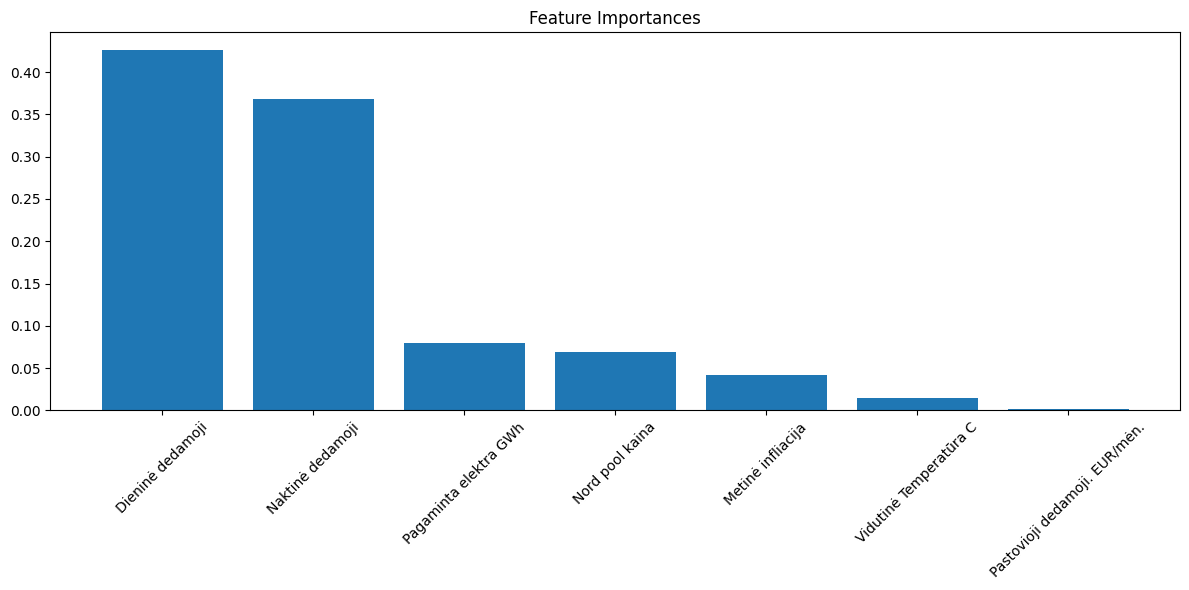

Geriausi parametrai: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Treniravimo tikslumas: 1.0
Testavimo tikslumas: 0.9130434782608695
Kryžminės validacijos (cv=5) tikslumo reikšmės: [1.         1.         1.         1.         0.91304348]
Kryžminės validacijos (cv=5) vidutinis tikslumas: 0.9826086956521738


In [7]:
from sklearn.ensemble import RandomForestClassifier
RandomForest_mokymasis(df_Elektra)

#### Gradient Boost Klasifikatorius ####

In [8]:
def GradientBoost_mokymasis(df, skaicius=5):
    df_testavimas = df
    bins = [0.1, 0.2, 0.4, float('inf')]
    labels = ['High', 'Medium', 'Low']
    df_testavimas['Kainų rėžiai'] = pd.cut(df_testavimas['Viena laiko zona'], bins=bins, labels=labels)

    # Pasiruošiame duomenis
    X = df_testavimas[['Dieninė dedamoji', 'Naktinė dedamoji', 'Pastovioji dedamoji. EUR/mėn.',
                    'Nord pool kaina', 'Metinė infliacija', 'Vidutinė Temperatūra C', 'Pagaminta elektra GWh']]
    y = df_testavimas['Kainų rėžiai']

    # Padalijame į treniravimo ir testavimo rinkinius
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Sukuriame Gradient Boosting klasifikatorių
    classifier = GradientBoostingClassifier(random_state=42)

    # Nustatome hiperparametrų tinklą
    param_grid = {
        'n_estimators': [10, 20],
        'max_depth': [3, 5],
        'learning_rate': [0.001, 0.01]
    }

    # Naudojame GridSearchCV geriausiems parametrams rasti
    grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=skaicius, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)

    # Geriausi parametrai
    best_params = grid_search.best_params_

    # Geriausias modelis
    best_model = grid_search.best_estimator_

    # Atliekame prognozes su geriausiu modeliu
    y_train_pred = best_model.predict(X_train_scaled)
    y_test_pred = best_model.predict(X_test_scaled)

    # Vertiname modelį
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Kryžminė validacija su pilnu duomenų rinkiniu
    X_combined = pd.concat([X_train, X_test])
    y_combined = pd.concat([y_train, y_test])
    X_combined_scaled = scaler.fit_transform(X_combined)

    cv_scores = cross_val_score(best_model, X_combined_scaled, y_combined, cv=5, scoring='accuracy')

    # Požymių svarba
    feature_importances = best_model.feature_importances_
    features = X.columns

    # Požymių svarbos vizualizacija
    indices = np.argsort(feature_importances)[::-1]
    plt.figure(figsize=(14, 6))
    plt.title("Feature Importances")
    plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
    plt.xticks(range(X.shape[1]), features[indices], rotation=45)
    plt.tight_layout()
    plt.show()

    # Rezultatų spausdinimas
    print(f'Geriausi parametrai: {best_params}')
    print(f'Treniravimo tikslumas: {train_accuracy}')
    print(f'Testavimo tikslumas: {test_accuracy}')

    print(f'Kryžminės validacijos (cv=5) tikslumo reikšmės: {cv_scores}')
    print(f'Kryžminės validacijos (cv=5) vidutinis tikslumas: {cv_scores.mean()}')

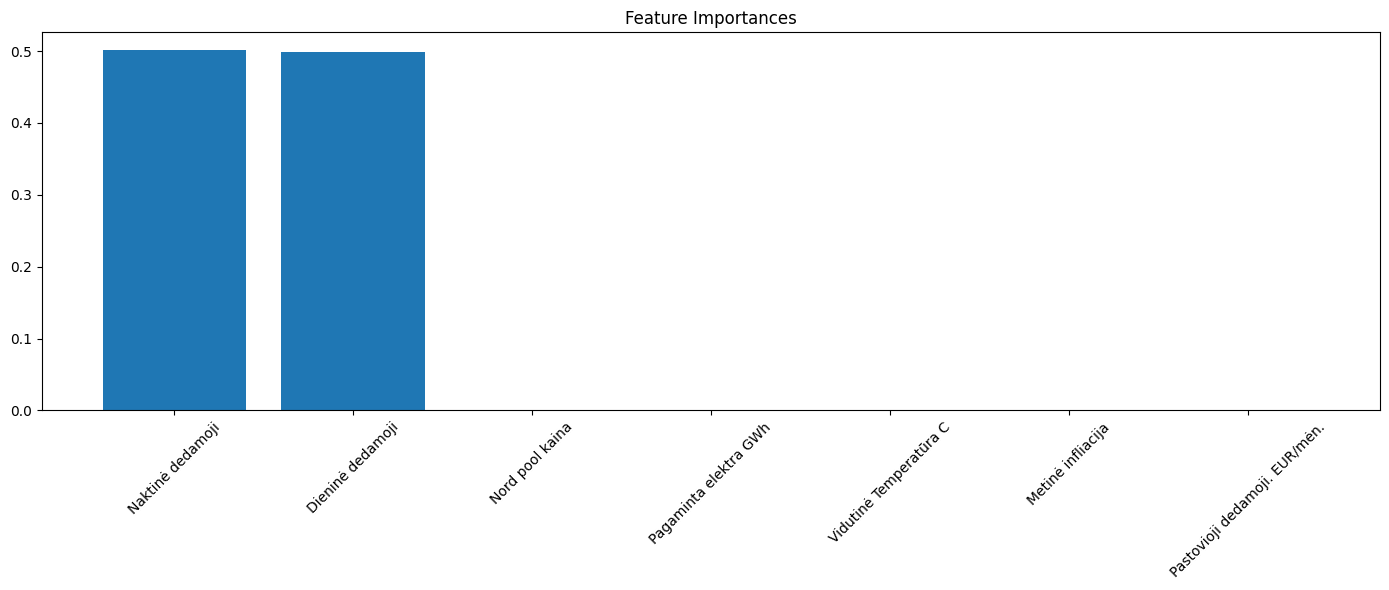

Geriausi parametrai: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 10}
Treniravimo tikslumas: 0.8804347826086957
Testavimo tikslumas: 0.9130434782608695
Kryžminės validacijos (cv=5) tikslumo reikšmės: [0.91304348 0.91304348 0.86956522 0.86956522 0.86956522]
Kryžminės validacijos (cv=5) vidutinis tikslumas: 0.8869565217391304


In [9]:
from sklearn.ensemble import GradientBoostingClassifier
GradientBoost_mokymasis(df_Elektra)